In [15]:
import os 
import torch
from dataset import Comma10kDataset, train_test_split, get_test_transforms
import matplotlib.pyplot as plt 

In [6]:
comma10k_dir = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k"
imgs_root = os.path.join(comma10k_dir, "imgs")
masks_root = os.path.join(comma10k_dir, "masks")
classes = [41, 76, 90, 124, 161]

In [7]:
train_imgs, test_imgs = train_test_split(imgs_root)

In [8]:
len(test_imgs)

989

In [12]:
test_dataset = Comma10kDataset(imgs_root, masks_root, test_imgs, classes, get_test_transforms())

In [21]:
for img, mask in test_dataset:
    print(img.size())
    print(mask.size())
    break

torch.Size([3, 448, 576])
torch.Size([5, 448, 576])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


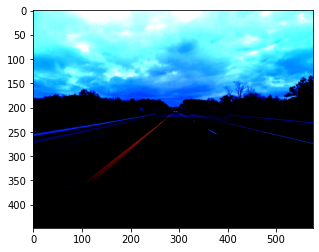

In [22]:
img = torch.transpose(img, 0, 2)
img = torch.transpose(img, 0, 1).numpy()
plt.imshow(img)

In [23]:
mask = mask.numpy()

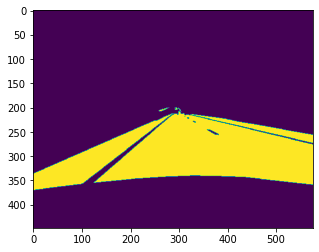

In [24]:
plt.imshow(mask[0])

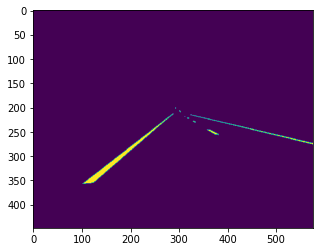

In [25]:
plt.imshow(mask[1])

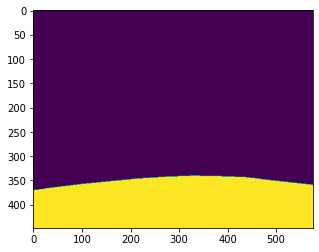

In [26]:
plt.imshow(mask[2])

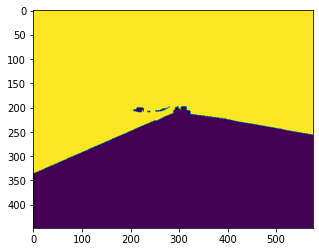

In [27]:
plt.imshow(mask[3])

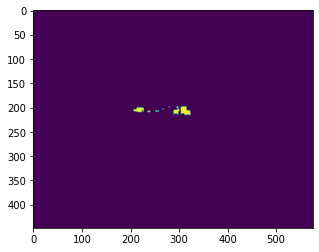

In [28]:
plt.imshow(mask[4])